In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import layers 
from keras import models
from keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from skimage import img_as_ubyte
from skimage.transform import resize

from scipy.ndimage.interpolation import rotate

Using TensorFlow backend.


## <b><font color='3C89F9'>Data load</font></b>

In [4]:
# train data
train_data = pd.read_csv('/kaggle/input/train.csv')

# test data
test_data = pd.read_csv('/kaggle/input/test.csv')

In [7]:
print('size train data:', train_data.shape)
print('size test data:', test_data.shape)

size train data: (42000, 785)
size test data: (28000, 784)


## <b><font color='3C89F9'>Data preparation</font></b>

In [5]:
# split dataset train data and test data for ML

X_model = train_data.drop('label', axis=1)
y_model = train_data['label'].copy()

Y_finish = test_data

print('size train data:', X_model.shape)
print('size train labels:', y_model.shape)
print('size finish test data:', Y_finish.shape)

size train data: (42000, 784)
size train labels: (42000,)
size finish test data: (28000, 784)


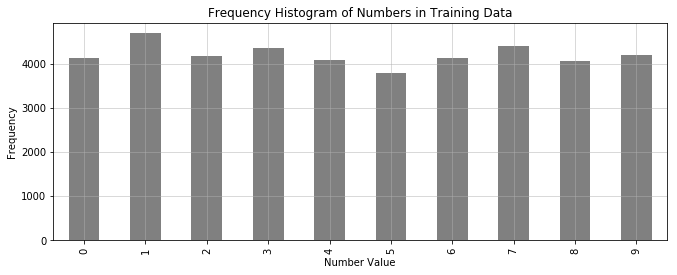

In [6]:
# frequency occurrence train labels
plt.subplots(figsize=(11,4))
y_model.value_counts().sort_index().plot('bar', color='grey')
plt.title("Frequency Histogram of Numbers in Training Data")
plt.xlabel("Number Value")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.6)

In [5]:
# functions add modify train data

def img_rotate(df_x, angle):
    """ function rotate image by angle """
    change_img = np.empty([df_x.shape[0], df_x.shape[1]])
    for i, image in enumerate(df_x.values):
        img = rotate(image.reshape(28, 28), angle, cval=0, reshape=False, order=0)
        change_img[i] = img.ravel()
    return pd.DataFrame(data=change_img, columns=df_x.columns)

def img_zoom(df_x, scale):
    """ function zoom image by scale """
    if (scale > 0.9) or (scale < -0.9):
        raise Exception('scale values must be between -0.9 and 0.9')
    if scale < 0:
        change_img = np.empty([df_x.shape[0], df_x.shape[1]])
        for i, image in enumerate(df_x.values):
            number_around = round(28*abs(scale)/2)
            img = image.reshape(28, 28).astype('float32').copy()
            img = np.pad(img, number_around, mode='constant') 
            img = resize(img, (28,28), anti_aliasing=False, mode='constant', cval=0, order=0)
            change_img[i] = img.ravel().astype('int64')
        return pd.DataFrame(data=change_img, columns=df_x.columns)
    elif scale >= 0:
        change_img = np.empty([df_x.shape[0], df_x.shape[1]])
        for i, image in enumerate(df_x.values):
            number_slice = round(28*abs(scale)/2)
            img = image.reshape(28, 28).astype('float32').copy()
            img = img[number_slice:28-number_slice, number_slice:28-number_slice]
            img = resize(img, (28,28), anti_aliasing=False, mode='constant', cval=0, order=0)
            change_img[i] = img.ravel().astype('int64')
        return pd.DataFrame(data=change_img, columns=df_x.columns)   


In [6]:
# split data train and test and convert to Keras model
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2)

In [7]:
# add modified images training
X_train_add = X_train.append(img_zoom(X_train, 0.17))
X_train_add = X_train_add.append(img_zoom(X_train, -0.2))

X_train_add = X_train_add.append(img_rotate(X_train, 10))
X_train_add = X_train_add.append(img_rotate(X_train, -10))

# add modified images labels
y_train_add = y_train.append(y_train)
y_train_add = y_train_add.append(y_train)

y_train_add = y_train_add.append(y_train)
y_train_add = y_train_add.append(y_train)

# set train and test with add images
X_train = X_train_add.copy()
y_train = y_train_add.copy()

# shuffle full training data
X_train, y_train = shuffle(X_train, y_train)

In [8]:
# convert train data to Keras model
X_train = X_train.values.reshape(X_train.shape[0], 28, 28 ,1)
X_train = X_train.astype('float32') / 255

X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1)
X_test = X_test.astype('float32') / 255

Y_finish = Y_finish.values.reshape(Y_finish.shape[0], 28, 28 ,1)
Y_finish = Y_finish.astype('float32') / 255

In [9]:
# # show few images
# plt.figure(figsize=(18,8))
# for i in range(75):  
#     plt.subplot(5, 15, i+1)
#     plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
#     plt.axis('off')
# plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
# plt.show()

## <b><font color='3C89F9'>Deep Learning</font></b></font> by Keras</b>

In [9]:
# function build model Keras
def build_model():
    # add dropout between layers
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    opt = optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# convert train labels to categorical Keras
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

cnn = build_model()
cnn.fit(X_train,
        y_train,
        epochs=1,
        batch_size=64)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
168000/168000 [==============================] - 122s 726us/step - loss: 0.1122 - acc: 0.9645


In [11]:
# get score test model
test_loss, test_acc = cnn.evaluate(X_test, y_test)
test_acc

8400/8400 [==============================] - 2s 212us/step


0.99

In [12]:
# predict test data
predict_test = cnn.predict_classes(X_test)
y_correct = np.argmax(y_test, axis=1)

correct_idx = np.nonzero(predict_test==y_correct)
incorrect_idx = np.nonzero(predict_test!=y_correct)

In [13]:
# show report test data
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_correct, predict_test, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       806
     Class 1       0.99      1.00      1.00       954
     Class 2       0.99      0.98      0.99       849
     Class 3       0.99      1.00      0.99       890
     Class 4       0.99      0.99      0.99       817
     Class 5       0.99      0.99      0.99       734
     Class 6       0.99      1.00      0.99       836
     Class 7       0.98      1.00      0.99       840
     Class 8       0.99      0.98      0.98       805
     Class 9       0.99      0.97      0.98       869

   micro avg       0.99      0.99      0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



## <b><font color='3C89F9'>Save results</font>

In [14]:
# predict finish test data
predict = cnn.predict_classes(Y_finish)

In [15]:
# create DataFrame predict finish data
df_out = pd.DataFrame({'ImageId': range(1, len(predict)+1),
                       'Label': predict})

In [16]:
# create answers for Kaggle csv
df_out.to_csv('mnist_cnn.csv', index=False, header=True)